In [31]:
from reportlab.lib import colors
from reportlab.lib.units import cm
from Bio.Graphics import GenomeDiagram
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.SeqUtils import GC
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
from IPython.display import Image
import seaborn as sns


round_paraneter = 3  


record = SeqIO.read("NC_009698_clo.gb", "genbank")

gd_diagram = GenomeDiagram.Diagram(record.id)
name = record.name
seq = record.seq
print(name)

NC_009698


In [32]:
def save_obj(obj, name):   # we have to store big dictionaries that take a lot of machine time
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):  # and load them
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [33]:
window = 1000
round_paraneter = 3

GC_dict = {}
if window%2 == 0:
    for i in range(len(seq)):
        if i%5 == 0:
            start = int(i- window/2)
            end = int(i + window/2)
            if start < 0:
                sub_seq = str(seq[-start:]) + str(seq[:end])
                GC_dict[i] = round(GC(sub_seq), round_paraneter)
            if start >=  0 and end <= len(seq):
                sub_seq = seq[start:end]
                GC_dict[i] = round(GC(sub_seq), round_paraneter)
            if end > len(seq):
                sub_seq = seq[start:] + seq[:len(seq) - end]
                GC_dict[i] = round(GC(sub_seq), round_paraneter)

print("Done")

Done


In [34]:
save_obj(GC_dict, name)  # you can just back up your dictionary

In [46]:
GC_dict = load_obj(name)  # or refresh it

In [35]:
x = list(GC_dict.keys())
y = list(GC_dict.values())

m = round(np.mean(y), round_paraneter)
s = round(statistics.stdev(y), round_paraneter)

l_up = round((m + s) * 1.35, round_paraneter)
l_down = round((m - s) * 0.65, round_paraneter)
print(len(x), m, s, l_up, l_down)

752112 28.186 4.18 43.694 15.604


In [36]:
gd_track_for_features = gd_diagram.new_track(1, name="Annotated Features")
gd_feature_set = gd_track_for_features.new_set()

for feature in record.features:
    if feature.type != "gene":
        #Exclude this feature
        continue
    #print(feature.qualifiers)
    gene_seq = str(feature.extract(seq))
    gene_GC = round(GC(gene_seq), round_paraneter)
    #print(l_down, gene_GC, l_up)
    if gene_GC < l_down:
        #print(feature.qualifiers['gene'], "down")
        color = colors.blue
        gd_feature_set.add_feature(feature, sigil="ARROW", arrowshaft_height=0.2,
                               color=color, label=True,
                               label_size = 25, label_angle=0)
    if gene_GC > l_up:
        #print(feature.qualifiers['gene'], "up")
        color = colors.red
        gd_feature_set.add_feature(feature, sigil="ARROW", arrowshaft_height=0.2,
                               color=color, label=True,
                               label_size = 25, label_angle=0)


In [3]:
#gd_diagram.draw(format="linear", fragments=40,start=0, end=len(record))
#gd_diagram.write("plasmid_linear_nice.png", "PNG")

In [4]:
#Image(filename='plasmid_linear_nice.png') 

In [37]:
gd_diagram.draw(format="circular", circular=True, pagesize=(80*cm,80*cm), start=0, end=len(record), circle_core = 0.3)
gd_diagram.write("Clostridium.png", "PNG")

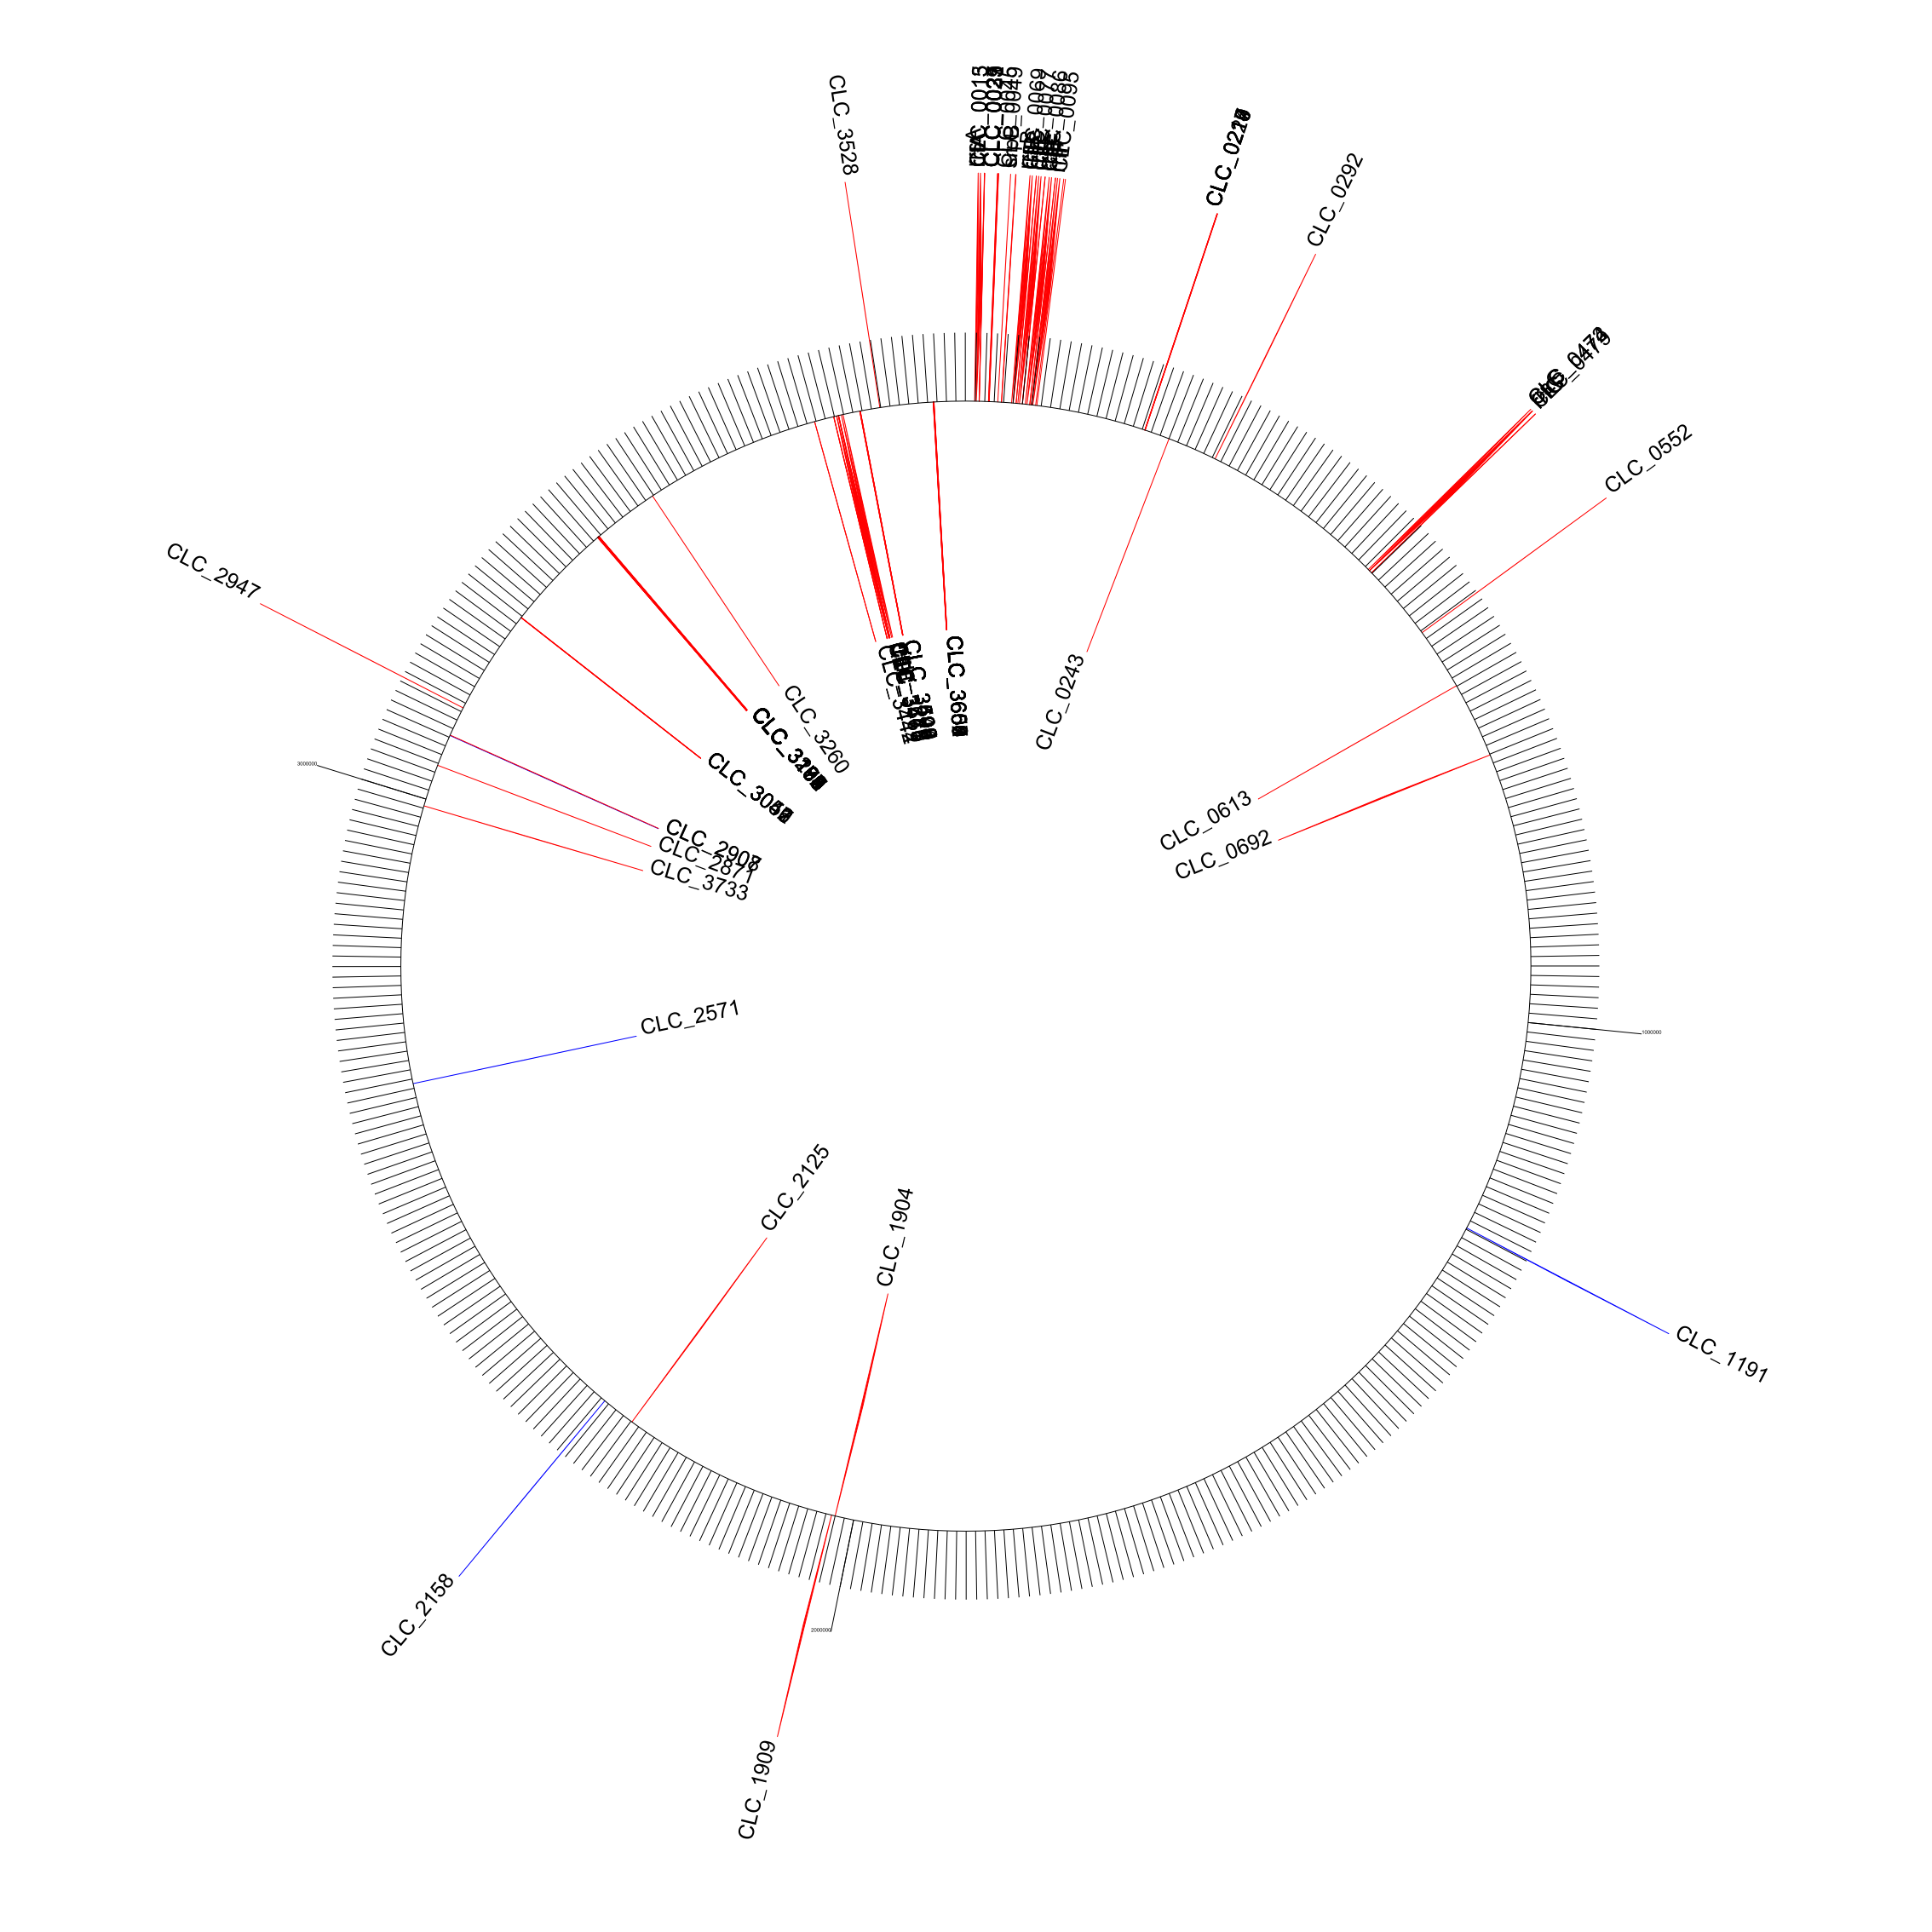

In [38]:
Image(filename="Clostridium.png") 

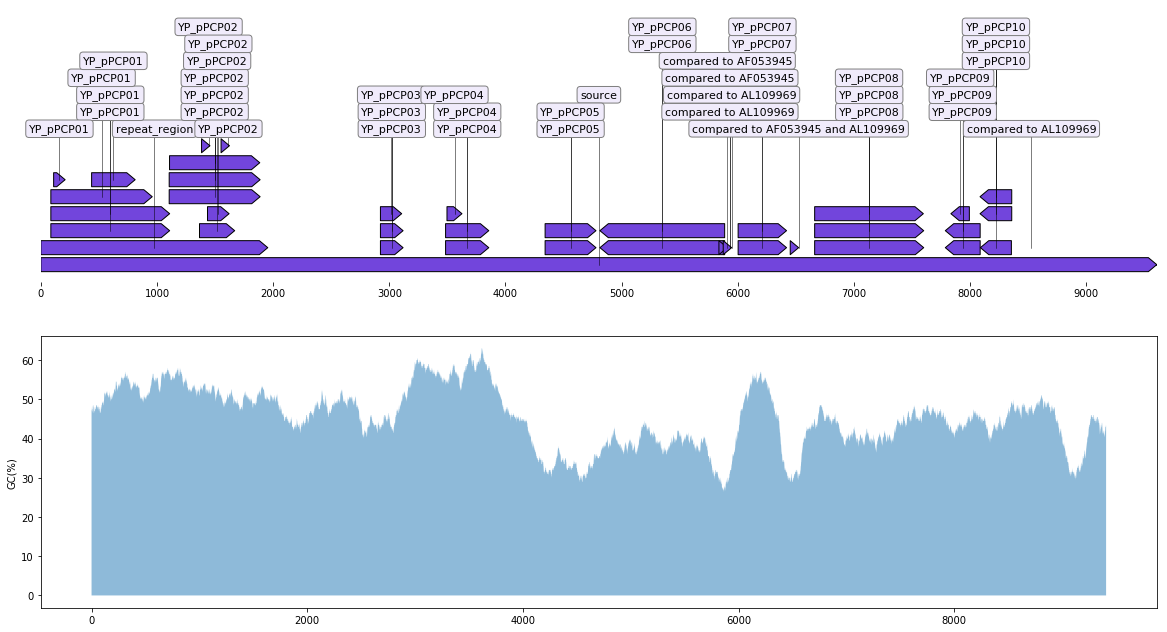

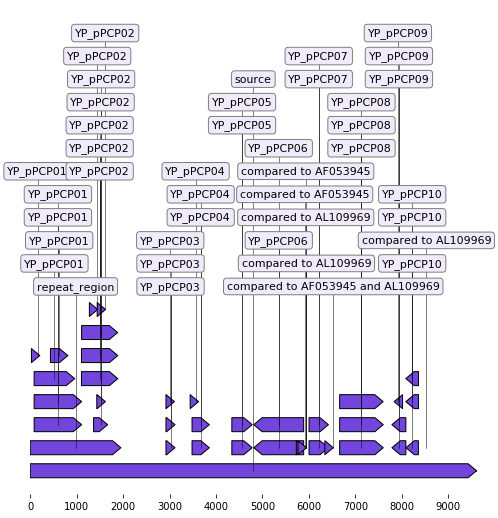

In [84]:
# only for short seqss
import matplotlib.pyplot as plt
from dna_features_viewer import BiopythonTranslator
from Bio import SeqIO
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 11), sharex=False)

# Parse the genbank file, plot annotations
record = SeqIO.read("NC_005816.gb", "genbank")
graphic_record = BiopythonTranslator().translate_record(record)
ax, levels = graphic_record.plot()
graphic_record.plot(ax=ax1, with_ruler=True)

# Plot the local GC content
def plot_local_gc_content(record, window_size, ax):
    gc_content = lambda s: 100.0*len([c for c in s if c in "GC"]) / len(s)
    yy = [gc_content(record.seq[i:i+window_size])
          for i in range(len(record.seq)-window_size)]
    #print(yy)
    xx = np.arange(len(record.seq)-window_size)
    #print(xx)
    ax.fill_between(xx, yy, alpha=0.5)
    ax.set_ylabel("GC(%)")

plot_local_gc_content(record, window_size=200, ax=ax2)

# Resize the figure
fig.savefig("with_plot.png")
#Image(filename='with_plot.png') 